In [ ]:
############################
# 1) SETUP AND IMPORTS
############################
!pip install focal-loss --quiet  # (Optional) if you want to try focal loss later

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from sklearn.metrics import f1_score

############################
# 2) UNZIP CHEXPERT DATASET
###########################
# Make sure you have "archive.zip" (the CheXpert dataset) in your Drive
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/chexpert

# Check folder
print("Files in /content/chexpert:")
print(os.listdir('/content/chexpert'))

Mounted at /content/drive
Files in /content/chexpert:
['valid', 'train.csv', 'valid.csv', 'train']


In [ ]:
############################
# 3) LOAD & INSPECT DATA
############################
train_csv_path = "/content/chexpert/train.csv"  # Adjust if needed
df = pd.read_csv(train_csv_path)
print("Total rows in train.csv:", len(df))

# All 14 CheXpert labels (for reference)
all_labels = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion",
    "Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax",
    "Pleural Effusion","Pleural Other","Fracture","Support Devices"
]

# OPTIONAL: quick distribution check
print("Label distribution (raw counts of 1, 0, -1, NaN) for each label:")
label_counts = {}
for label in all_labels:
    col = df[label]
    counts = {
        "1.0": (col == 1.0).sum(),
        "0.0": (col == 0.0).sum(),
        "-1.0": (col == -1.0).sum(),
        "NaN": col.isna().sum()
    }
    label_counts[label] = counts
label_counts_df = pd.DataFrame(label_counts).T
label_counts_df.columns = ["Count_1.0", "Count_0.0", "Count_-1.0", "Count_NaN"]
display(label_counts_df)

Total rows in train.csv: 223414
Label distribution (raw counts of 1, 0, -1, NaN) for each label:


,Count_1.0,Count_0.0,Count_-1.0,Count_NaN
No Finding,22381,0,0,201033
Enlarged Cardiomediastinum,10798,21638,12403,178575
Cardiomegaly,27000,11116,8087,177211
Lung Opacity,105581,6599,5598,105636
Lung Lesion,9186,1270,1488,211470
Edema,52246,20726,12984,137458
Consolidation,14783,28097,27742,152792
Pneumonia,6039,2799,18770,195806
Atelectasis,33376,1328,33739,154971
Pneumothorax,19448,56341,3145,144480


In [ ]:


############################
# 4) FILTER DATA & DEFINE LABELS
############################
# Load metadata
csv_path = "/content/chexpert/train.csv"
df = pd.read_csv(csv_path)

# Add full image path
df["filepath"] = df["Path"].apply(lambda x: str(Path("/content/chexpert") / Path(x).relative_to("CheXpert-v1.0-small")))

# Filter to frontal images only
df = df[df["Frontal/Lateral"] == "Frontal"]

# Define training labels
target_labels = ["Pleural Effusion", "Edema", "Cardiomegaly"]

# Clean labels: replace -1.0 with 0.0 and fill NaNs with 0.0
df[target_labels] = df[target_labels].replace(-1.0, 0).fillna(0)

# Create 'No Finding' column (for analysis only)
df["No Finding"] = (df[target_labels].sum(axis=1) == 0).astype(int)

# Filter only images that exist
df = df[df["filepath"].apply(lambda x: Path(x).is_file())].copy()

# Stratified sampling of positives per class
def stratified_sample(df, label_col, n_per_class):
    sampled = []
    for label in label_col:
        positives = df[df[label] == 1].sample(n=min(n_per_class, df[df[label] == 1].shape[0]), random_state=42)
        sampled.append(positives)
    return pd.concat(sampled).drop_duplicates()

# Sample data for training
df = stratified_sample(df, target_labels, 2000)

# Display filtered shape and class balance
print("Filtered shape:", df.shape)
display(df[target_labels + ["No Finding"]].apply(pd.Series.value_counts).fillna(0).astype(int).T)

# Split into train/val sets
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")


from tensorflow.keras import backend as K
K.clear_session()


<ipython-input-48-a8dd8e8489e1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_labels] = df[target_labels].replace(-1.0, 0).fillna(0)
<ipython-input-48-a8dd8e8489e1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["No Finding"] = (df[target_labels].sum(axis=1) == 0).astype(int)


Filtered shape: (5913, 20)


,0.0,1.0
Pleural Effusion,2080,3833
Edema,2398,3515
Cardiomegaly,3277,2636
No Finding,5913,0


Train set shape: (4730, 20)
Validation set shape: (1183, 20)


In [ ]:
############################
# 6) IMAGE DATA GENERATORS &  CUSTOM SUBSAMPLE SEQUENCE
############################
# We will use color mode = "rgb" so that our DenseNet (pretrained on ImageNet) can handle 3 channels.
# You can replicate grayscale images into three channels, but typically just letting Keras load them as RGB is fine.

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class SubsampleSequence(Sequence):
    def __init__(
        self,
        df,
        x_col,
        y_cols,
        datagen,
        img_size,
        batch_size,
        subsample_size,
        **kwargs              # collect any extra args
    ):
        super().__init__(**kwargs)              # call the parent constructor
        self.df = df.reset_index(drop=True)
        self.x_col = x_col
        self.y_cols = y_cols
        self.datagen = datagen
        self.img_size = img_size
        self.batch_size = batch_size
        self.subsample_size = min(subsample_size, len(self.df))
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.subsample_size / self.batch_size))

    def __getitem__(self, idx):
        batch_idx = self.sample_indices[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_df = self.df.iloc[batch_idx]

        # load & preprocess images
        batch_x = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        for i, fp in enumerate(batch_df[self.x_col]):
            img = load_img(fp, target_size=self.img_size)
            batch_x[i] = img_to_array(img)
        batch_x = preprocess_input(batch_x)

        # get labels
        batch_y = batch_df[self.y_cols].values.astype(np.float32)

        # apply augmentations
        gen = self.datagen.flow(batch_x, batch_y, batch_size=self.batch_size, shuffle=False)
        return next(gen)   # returns (batch_x_aug, batch_y_aug)

    def on_epoch_end(self):
        self.sample_indices = np.random.choice(
            self.indices, size=self.subsample_size, replace=False
        )

# parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
SUBSAMPLE_SIZE = 2000   # e.g. use 2k random samples each epoch

# create  standard ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# instantiate the sequence
train_sequence = SubsampleSequence(
    df=train_df,
    x_col="filepath",
    y_cols=target_labels,
    datagen=train_datagen,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subsample_size=SUBSAMPLE_SIZE
)

# validation generator stays the same
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col=target_labels,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1183 validated image filenames.


In [ ]:
############################
# 7) BUILD PRETRAINED DENSENET
############################
#!pip install tensorflow-addons --quiet --upgrade
from focal_loss import BinaryFocalLoss
#import tensorflow_addons as tfa
from tensorflow.keras.losses import BinaryCrossentropy

def create_densenet_model(input_shape=(256,256, 3), num_classes=len(target_labels), freeze_until='conv5_block2_concat'): # Changed input_shape to (256, 256, 3)
    """
    freeze_until: layer name or index until which layers are frozen (optional).
    """
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    ## OPTIONAL: Freeze some or all layers of base_model. For example:
    #if freeze_until is not None:
     #  trainable = False
     #  for layer in base_model.layers:
     #      if layer.name == freeze_until:
     #       trainable = True
    #       layer.trainable = trainable
    #else:
         # freeze entire base_model
    for layer in base_model.layers:
          #layer.trainable = False
          layer.trainable = True if 'conv5' in layer.name else False

    # Add new top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    # from focal_loss import BinaryFocalLoss
    # model.compile(optimizer=Adam(1e-4), loss=BinaryFocalLoss(gamma=2), metrics=['accuracy'])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        #loss=BinaryFocalLoss(gamma=2),
        loss=BinaryCrossentropy(),
        #loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=False, label_smoothing=0.05),
        metrics=[AUC(multi_label=True, name='auc')]
    )

    return model

model = create_densenet_model(input_shape=(256, 256, 3), num_classes=len(target_labels)) # Changed input_shape to (256, 256, 3)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 262, 262,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 2,161,155 (8.24 MB)

 Non-trainable params: 4,879,424 (18.61 MB)

In [ ]:
############################
# 7.5) RESUME FROM LATEST CHECKPOINT (if exists)
############################
from tensorflow.keras.models import load_model
import glob

checkpoint_dir = "/content/drive/MyDrive/chexpert_checkpoints"
latest_checkpoint = None


# Find all saved models
checkpoint_files = sorted(
    glob.glob(os.path.join(checkpoint_dir, "*.keras")),
    key=os.path.getmtime  # sort by modification time
)

if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"🔁 Resuming from latest checkpoint:\n{latest_checkpoint}")
    model = load_model(latest_checkpoint)
else:
    print("🆕 No checkpoint found, starting training from scratch.")


🔁 Resuming from latest checkpoint:
/content/drive/MyDrive/chexpert_checkpoints/epoch_08-val_loss_0.2180.keras


In [ ]:

############################
# 8) TRAIN MODEL (WITH CHECKPOINTING)
############################
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Create a folder in your Google Drive to store the checkpoints
checkpoint_dir = "/content/drive/MyDrive/chexpert_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)



checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}-val_loss_{val_loss:.4f}.keras"),
    save_best_only=False,
    save_weights_only=False,  # saves only weights, much smaller
    verbose=1
)
#

# Full callbacks list,
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    checkpoint_callback  # Added checkpointing here
]


# Train the model
history = model.fit(
    train_sequence,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - auc: 0.7004 - loss: 0.1567
Epoch 1: saving model to /content/drive/MyDrive/chexpert_checkpoints/epoch_01-val_loss_0.1995.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 509ms/step - auc: 0.7003 - loss: 0.1567 - val_auc: 0.5705 - val_loss: 0.1995 - learning_rate: 2.5000e-05
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - auc: 0.6646 - loss: 0.1614
Epoch 2: saving model to /content/drive/MyDrive/chexpert_checkpoints/epoch_02-val_loss_0.2047.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - auc: 0.6646 - loss: 0.1614 - val_auc: 0.5697 - val_loss: 0.2047 - learning_rate: 2.5000e-05
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - auc: 0.6883 - loss: 0.1568
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 3: saving model to /content/drive/MyDrive/chexpert_checkpoints/epoch_03-val_loss_0.2206.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - auc: 0.6883 - loss: 0.1568 - val_auc: 0.5678 - val_

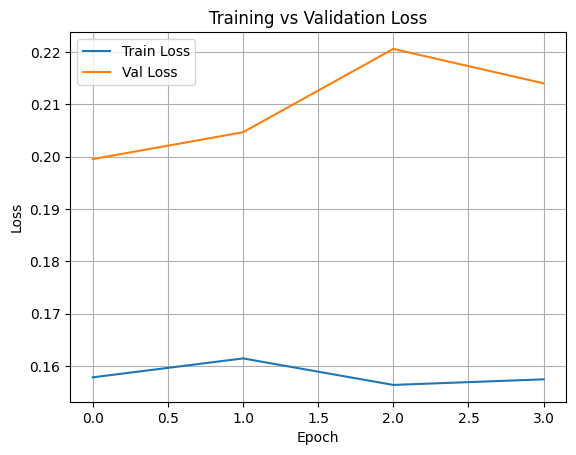

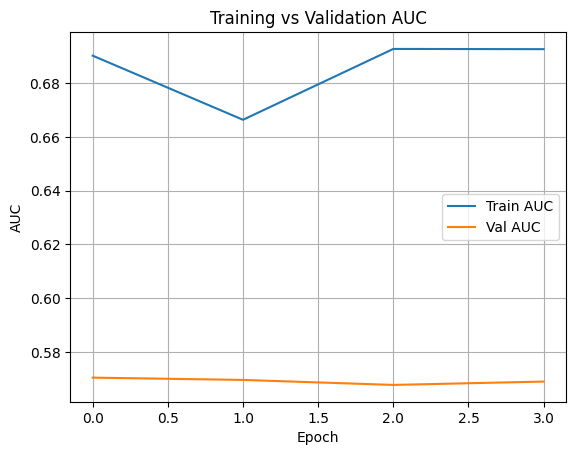

In [ ]:
# 📈 Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Plot AUC
if 'auc' in history.history:
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title("Training vs Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
############################
# 9) EVALUATE MODEL
############################
# Evaluate final model on val set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Predict probabilities
y_pred_prob = model.predict(val_generator)
y_true = val_generator.labels  # ground truth

best_thresholds = []

for i, label in enumerate(target_labels):
    best_thresh = 0.5
    best_f1 = 0
    for t in np.arange(0.1, 0.9, 0.05):
        temp_pred = (y_pred_prob[:, i] > t).astype(int)
        f1 = f1_score(y_true[:, i], temp_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    best_thresholds.append(best_thresh)
    print(f"{label}: Best threshold={best_thresh:.2f}, F1={best_f1:.4f}")

#y_pred = np.zeros_like(y_pred_prob)

for i, threshold in enumerate(best_thresholds):
    y_pred[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

# Binarize with threshold=0.5
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_labels))

# AUC for each class
print("AUC Scores per Label:")
for i, label in enumerate(target_labels):
    auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    print(f"{label}: {auc_score:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.5791 - loss: 0.1963
Validation Loss: 0.1995
Validation Accuracy: 0.5705
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step
Pleural Effusion: Best threshold=0.30, F1=0.7858
Edema: Best threshold=0.40, F1=0.7471
Cardiomegaly: Best threshold=0.45, F1=0.6181

Classification Report:
                  precision    recall  f1-score   support

Pleural Effusion       0.66      0.81      0.73       765
           Edema       0.62      0.73      0.67       699
    Cardiomegaly       0.45      0.97      0.61       528

       micro avg       0.57      0.82      0.67      1992
       macro avg       0.58      0.84      0.67      1992
    weighted avg       0.59      0.82      0.68      1992
     samples avg       0.56      0.82      0.63      1992

AUC Scores per Label:
Pleural Effusion: 0.5743
Edema: 0.5757
Cardiomegaly: 0.5621


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


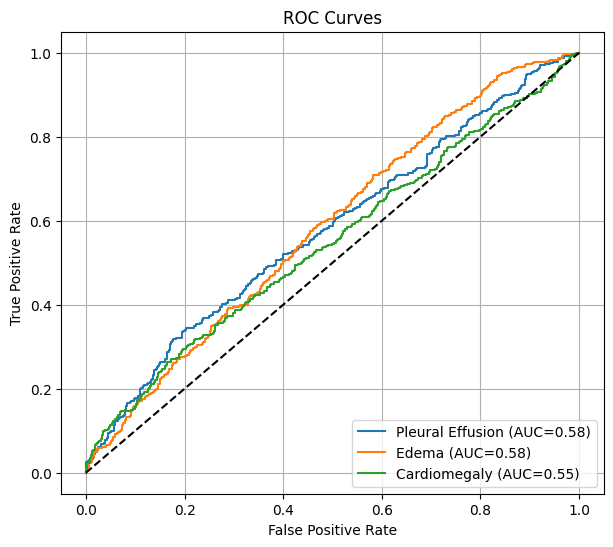

In [ ]:
############################
# 10) PLOT ROC CURVES
############################
plt.figure(figsize=(7,6))
for i, label in enumerate(target_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

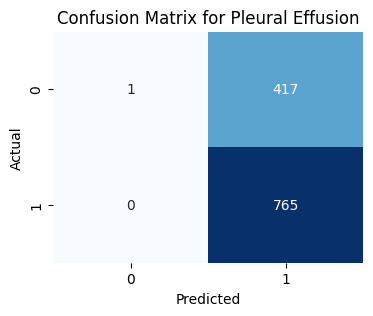

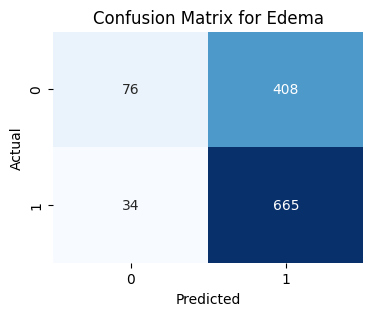

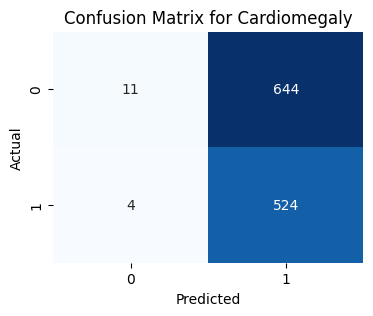

In [ ]:
############################
# 11) CONFUSION MATRIX
############################
for i, label in enumerate(target_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Showing Grad-CAM for:
/content/chexpert/train/patient26914/study2/view1_frontal.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_430']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


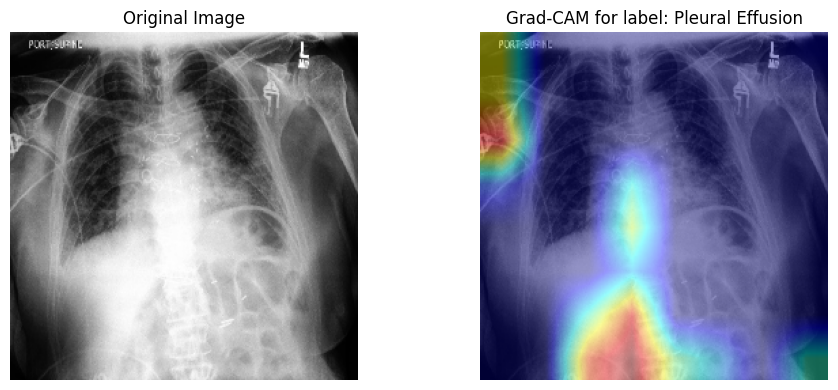

In [ ]:

############################
# 12) GRAD-CAM DEMO
############################
# Example Grad-CAM for a single image from the validation set
import cv2

def plot_gradcam(model, img_path, layer_name, label_index=0):
    """
    Generates Grad-CAM heatmap for a single label_index on a single image.
    model: your trained model
    img_path: path to an image
    layer_name: name of the last conv layer in DenseNet (e.g., 'conv5_block16_concat')
    label_index: which label (0.. num_classes-1) to visualize
    """
    # 1) Load & preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # DenseNet's preprocess

    # 2) Forward pass
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, label_index]  # focusing on specific label

    # 3) Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    # Global average pooling across spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4) Weight the channels by corresponding gradients
    conv_outputs = conv_outputs[0]          # shape: (H, W, Channels)
    pooled_grads = pooled_grads            # shape: (Channels,)
    conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)  # average out channels -> shape: (H, W)

    # 5) Normalize the heatmap for visualization
    heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # 6) Superimpose on original image
    # Load original image in openCV
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, IMG_SIZE)

    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img_orig, 0.6, 0)

    # 7) Display side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Grad-CAM for label: {target_labels[label_index]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Pick a random validation sample
sample_idx = np.random.randint(len(val_df))
sample_path = val_df.iloc[sample_idx]["filepath"]
print(f"Showing Grad-CAM for:\n{sample_path}")

# The last DenseNet layer you can target is typically "conv5_block16_concat" or check model.summary()
plot_gradcam(model, sample_path, layer_name='conv5_block16_concat', label_index=0)


In [ ]:
import os
import shutil

# Create output folder
os.makedirs("examples", exist_ok=True)

# Adjust the base path to where your images are stored in Colab
base_path = "/content/chexpert"  # <-- corrected path

# Select one image for each condition
sample_edema = df[(df["Frontal/Lateral"] == "Frontal") & (df["Edema"] == 1)].iloc[0]
sample_effusion = df[(df["Frontal/Lateral"] == "Frontal") & (df["Pleural Effusion"] == 1)].iloc[0]
sample_cardiomegaly = df[(df["Frontal/Lateral"] == "Frontal") & (df["Cardiomegaly"] == 1)].iloc[0]

# Copy selected images into /examples folder
# Use the complete path by removing 'CheXpert-v1.0-small/' from sample_edema['Path'] to join correctly

# Note: Replace 'CheXpert-v1.0-small/' with '' as filepaths are relative to base_path
shutil.copy(os.path.join(base_path, sample_edema['Path'].replace('CheXpert-v1.0-small/', '')), "examples/edema.jpg")
shutil.copy(os.path.join(base_path, sample_effusion['Path'].replace('CheXpert-v1.0-small/', '')), "examples/effusion.jpg")
shutil.copy(os.path.join(base_path, sample_cardiomegaly['Path'].replace('CheXpert-v1.0-small/', '')), "examples/cardiomegaly.jpg")


print("✅ Example images saved to /examples")

In [ ]:
from google.colab import files
files.download("examples/edema.jpg")
files.download("examples/effusion.jpg")
files.download("examples/cardiomegaly.jpg")
